# Data Cleaning

In this notebook, we clean the data and format it based on our requirements. We start by importing, exploring and filtering our two dataframes: roads and BMMS. 
Following that, we identify intersections on the roads by a two-step process: (1) detecting road pairs that likely intersect and (2) calculating distance matrices on these pairs to determine the point of intersections.
After intersections are identified, based on these intersection points and bridge data, we construct the data file to be read by the simulation model.

## Data Import and Exploration

In [1]:
import pandas as pd
import itertools
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
from haversine import haversine
import time
import warnings

warnings.filterwarnings("ignore")  # to ignore depreciation warnings

start_time = time.time()

from IPython.display import Image

In [2]:
roads = pd.read_csv("../data/_roads3.csv")
bridges = pd.read_excel("../data/BMMS_overview.xlsx")

In [3]:
roads.info() # to see the number of rows, column names and brief summaries

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51348 entries, 0 to 51347
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   road      51348 non-null  object 
 1   chainage  51348 non-null  float64
 2   lrp       51348 non-null  object 
 3   lat       51348 non-null  float64
 4   lon       51348 non-null  float64
 5   gap       9074 non-null   object 
 6   type      51348 non-null  object 
 7   name      51348 non-null  object 
dtypes: float64(3), object(5)
memory usage: 3.1+ MB


In [4]:
roads.head() # to observe the first 5 columns of the dataframe

,road,chainage,lrp,lat,lon,gap,type,name
0,N1,0.000,LRPS,23.706028,90.443333,NaN,Others,Start of Road after Jatrabari Flyover infront...
1,N1,0.814,LRPSa,23.702917,90.450417,NaN,Culvert,Box Culvert
2,N1,0.822,LRPSb,23.702778,90.450472,NaN,CrossRoad,Intersection with Z1101
3,N1,1.000,LRP001,23.702139,90.451972,NaN,KmPost,Km post missing
4,N1,2.000,LRP002,23.697889,90.460583,NaN,KmPost,Km post missing


In [5]:
bridges.info() # to see the number of rows, column names and brief summaries

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20415 entries, 0 to 20414
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   road              20415 non-null  object 
 1   km                20415 non-null  float64
 2   type              20415 non-null  object 
 3   LRPName           20415 non-null  object 
 4   name              20100 non-null  object 
 5   length            20406 non-null  float64
 6   condition         20415 non-null  object 
 7   structureNr       20415 non-null  int64  
 8   roadName          20415 non-null  object 
 9   chainage          20415 non-null  float64
 10  width             17408 non-null  float64
 11  constructionYear  17407 non-null  float64
 12  spans             17408 non-null  float64
 13  zone              20415 non-null  object 
 14  circle            20415 non-null  object 
 15  division          20415 non-null  object 
 16  sub-division      20415 non-null  object

In [6]:
bridges.head()

,road,km,type,LRPName,name,length,condition,structureNr,roadName,chainage,width,constructionYear,spans,zone,circle,division,sub-division,lat,lon,EstimatedLoc
0,N1,1.800,Box Culvert,LRP001a,.,11.30,A,117861,Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...,1.800,19.5,2005.0,2.0,Dhaka,Dhaka,Narayanganj,Narayanganj-1,23.698739,90.458861,interpolate
1,N1,4.925,Box Culvert,LRP004b,.,6.60,A,117862,Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...,4.925,35.4,2006.0,1.0,Dhaka,Dhaka,Narayanganj,Narayanganj-1,23.694664,90.487775,interpolate
2,N1,8.976,PC Girder Bridge,LRP008b,Kanch pur Bridge.,394.23,A,119889,Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...,8.976,NaN,NaN,NaN,Dhaka,Dhaka,Narayanganj,Narayanganj-1,23.705060,90.523214,interpolate
3,N1,10.880,Box Culvert,LRP010b,NOYAPARA CULVERT,6.30,A,112531,Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...,10.880,12.2,1992.0,2.0,Dhaka,Dhaka,Narayanganj,Vitikandi,23.694391,90.537574,interpolate
4,N1,10.897,Box Culvert,LRP010c,ADUPUR CULVERT,6.30,A,112532,Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...,10.897,12.2,1984.0,2.0,Dhaka,Dhaka,Narayanganj,Vitikandi,23.694302,90.537707,interpolate


## Data Filtering

Let's check how many roads we initially have on the dataset.

In [7]:
print("There are", len(roads.road.unique()), "roads in the roads data")

There are 847 roads in the roads data


Regarding the scope of the project, we will eliminate the roads that are not classified as N.

In [8]:
roads = roads[roads["road"].str.contains("R")==False] # to eliminate R roads
roads = roads[roads["road"].str.contains("Z")==False] # to eliminate Z roads

roads.reset_index()
print("After the elimination of R and Z roads,",
      "there are", len(roads.road.unique()), "roads left in the roads data")

After the elimination of R and Z roads, there are 88 roads left in the roads data


Also, we want to exclude the roads that are shorter than 25 kms. To do that, we will use the ending LRPs (LRPEs). In case the chainage of a road's LRPE is smaller than 25, the road will be excluded.

In [9]:
# to create a dataframe with LRPEs only
roads_LRPE = roads.copy()
roads_LRPE = roads_LRPE[roads_LRPE["lrp"].str.contains("LRPE") == True]
print("There are", len(roads.road.unique()), "roads in the roads data, but only",
     len(roads_LRPE.road.unique()), "LRPEs are available.")

There are 88 roads in the roads data, but only 83 LRPEs are available.


Strangely, there are two roads for which LRPE is not available. In that case, we will use the last available information.

In [10]:
roads_LRPE = roads.drop_duplicates(subset=['road'], keep='last')
len(roads_LRPE)

88

In [11]:
# to store the name of the roads to be excluded
threshold = 25
roads_LRPE = roads_LRPE[roads_LRPE.chainage < threshold]
list_to_delete =roads_LRPE['road'].tolist()
print("There are",len(list_to_delete), "roads that are shorter than", threshold, "km")

There are 58 roads that are shorter than 25 km


Now, let's exclude these roads from our roads dataframe.

In [12]:
roads = roads[roads["road"].str.contains('|'.join(list_to_delete))==False]

roads.reset_index()
print("After the elimination of short roads,",
      "there are", len(roads.road.unique()), "roads left in the roads data")

After the elimination of short roads, there are 30 roads left in the roads data


Now, let's filter the bridge data based on this set of roads.

In [13]:
list_to_keep = roads.road.unique()

print("Initially, there were", len(bridges), "bridges")
# eliminate based on list_to_keep
bridges = bridges[bridges["road"].str.contains('|'.join(list_to_keep))==True]
print("After the elimination based on road filtering,",
      "there are", len(bridges), "bridges left.")

Initially, there were 20415 bridges
After the elimination based on road filtering, there are 4322 bridges left.


## Identifying Intersections

### 1. Detecting road pairs

In order to detect the roads that likely intersect, we came up with a basic algorithm: checking all the possible combinations of LRPs between the two roads. However, we acknowledge that this algorithm is computationally heavy (O(n^2)). As these pairs will be analyzed in detail in **2. Distance matrices**, we decided to break after a match is found to improve the velocity.

In [14]:
# this function takes a database and a road name as input, and 
# returns an array where the LRP details of the road of interest is kept
def db_to_array(db, road_name, lrp_column = "lrp", lat_column = "lat", lon_column = "lon"):
    db = db.loc[db['road'] == road_name]
    result = []
    for index, row in db.iterrows():
        result.append([row[lrp_column], row[lat_column], row[lon_column]])
    return result

In [15]:
# let's try the function with N1
road_name = "N1"
print("Number of LRPs on the road", road_name, ":", len(db_to_array(roads, road_name)))

Number of LRPs on the road N1 : 1339


In [16]:
# when given a pair of LRP details, 
# this function returns whether the lattitude and longitude percentage differences
# are significantly small, i.e. similarity
def check_similarity(lrp1, lrp2, significance_level = 0.001):
    # both lrp1 and lrp2 should be arrays where
    # 0th element = lrp reference,
    # 1st element = latitude,
    # 2nd element = longitude
    if lrp1[1] > lrp1[1]:
        dif_lat_per = ((lrp1[1] - lrp2[1]) / lrp1[1])
    else:
        dif_lat_per = ((lrp2[1] - lrp1[1]) / lrp2[1])
    if lrp1[2] > lrp2[2]:
        dif_lon_per = ((lrp1[2] - lrp2[2]) / lrp1[2])
    else:
        dif_lon_per = ((lrp2[2] - lrp1[2]) / lrp2[2])
    if dif_lat_per < significance_level and dif_lon_per < significance_level:
        return True
    else:
        return False

In [17]:
def array_similarity(arr1, arr2):
    for n1 in arr1:
        for n2 in arr2:
            if check_similarity(n1, n2) == True:
                # since we found a match there is no need to keep looking for others
                return True
    # if no match is found, then the function should return false
    return False

In [18]:
def road_similarity(db, road_name1, road_name2):
    arr1 = db_to_array(db, road_name1)
    arr2 = db_to_array(db, road_name2)
    return array_similarity(arr1, arr2)

In [19]:
# let's test our function with two pairs:
print("Result from similarity test for N1 and N2:",road_similarity(roads,"N1", "N2"))
# let's try
print("Result from similarity test for N1 and N509:",road_similarity(roads,"N1", "N509"))

Result from similarity test for N1 and N2: True
Result from similarity test for N1 and N509: False


First, we want to filter the roads that are connected to neither N1 nor N1.

In [20]:
side_roads = [item for item in list_to_keep if item not in ("N1", "N2")]
print("There are",len(side_roads), "side roads")

There are 28 side roads


In [21]:
similar_pairs = [["N1", "N2"]] # we already know that N1 and N2 are connected
side_roads_to_keep = []

for road_name in side_roads:
    similarity_found = False # we will start by assuming that we won't find a similarity
    
    # first, we will check whether we detect a hint of connection with N1
    if road_similarity(roads, "N1", road_name):
        similarity_found = True
        similar_pairs.append(["N1", road_name])
    
    # then, we will check whether we detect a hint of connection with N2
    if road_similarity(roads, "N2", road_name):
        similarity_found = True
        similar_pairs.append(["N2", road_name])
    
    # if at least one of these functions returned a match, then we will keep the road
    if similarity_found:
        side_roads_to_keep.append(road_name)
        

In [22]:
# so, the list of roads to be kept is the following:
list_to_keep = np.concatenate((["N1", "N2"],side_roads_to_keep))
list_to_keep

array(['N1', 'N2', 'N102', 'N104', 'N105', 'N106', 'N204', 'N207', 'N208',
       'N8', 'N809'], dtype='<U4')

In [23]:
# the road pairs for which intersections are to be identified are the following:
similar_pairs

[['N1', 'N2'],
 ['N1', 'N102'],
 ['N2', 'N102'],
 ['N1', 'N104'],
 ['N2', 'N104'],
 ['N1', 'N105'],
 ['N2', 'N105'],
 ['N1', 'N106'],
 ['N2', 'N106'],
 ['N2', 'N204'],
 ['N2', 'N207'],
 ['N2', 'N208'],
 ['N1', 'N8'],
 ['N2', 'N8'],
 ['N1', 'N809'],
 ['N2', 'N809']]

Here is the code if we decide on including other N-roads intersections:

In [24]:
side_road_pairs = []
for i in range(len(side_roads_to_keep)):
    side_road_1 = side_roads_to_keep[i]
    for j in range(i+1,len(side_roads_to_keep)):
        side_road_2 = side_roads_to_keep[j]
        if road_similarity(roads, side_road_1, side_road_2):
            side_road_pairs.append([side_road_1, side_road_2])
len(side_road_pairs)

6

### 2. Distance matrices

In [25]:
roads['road_lrp'] = roads[['road', 'lrp']].agg('_'.join, axis=1) # creating supporting column with road name and lrp concatenated
roads['coordinates'] = list(zip(roads.lat, roads.lon)) # creating supporting column with coordinates (lat,lon)
roads.head()

,road,chainage,lrp,lat,lon,gap,type,name,road_lrp,coordinates
0,N1,0.000,LRPS,23.706028,90.443333,NaN,Others,Start of Road after Jatrabari Flyover infront...,N1_LRPS,"(23.7060278, 90.443333)"
1,N1,0.814,LRPSa,23.702917,90.450417,NaN,Culvert,Box Culvert,N1_LRPSa,"(23.7029167, 90.4504167)"
2,N1,0.822,LRPSb,23.702778,90.450472,NaN,CrossRoad,Intersection with Z1101,N1_LRPSb,"(23.7027778, 90.4504722)"
3,N1,1.000,LRP001,23.702139,90.451972,NaN,KmPost,Km post missing,N1_LRP001,"(23.7021389, 90.4519722)"
4,N1,2.000,LRP002,23.697889,90.460583,NaN,KmPost,Km post missing,N1_LRP002,"(23.6978886, 90.4605833)"


#### *Computing distances*
The distance **between each point from road i to road j** was calculated using scipy.spatial.distance and haversine metric. After performing the calculations, the matrix was converted into a dataframe similar to the one depicted below, in which every row concerns a point from road i and every column concerns a point from road j

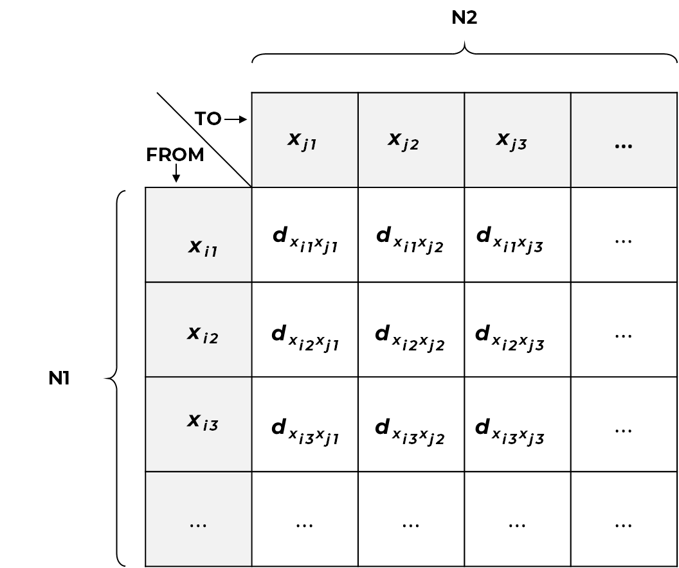

In [26]:
Image("../img/distance_matrix example.png")

We created a function to return the filtered dataframes from the roads dataset, so we can calculate the distance between ear pair or roads as stated in similar_pairs list above

In [27]:
def filter_dataframes(from_road,to_road):
    """
    
    Returns filtered dataframes from the original roads data based on the specific roads of interest (from_road and to_road)

    """
    df_from = roads.loc[roads['road']== from_road].copy()
    df_from = df_from.sort_values(by='chainage', ascending=True)
    df_from = df_from.reset_index()
    df_from = df_from.iloc[: , 1:]

    df_to = roads.loc[roads['road']== to_road].copy()
    df_to = df_to.sort_values(by='chainage', ascending=True)
    df_to = df_to.reset_index()
    df_to = df_to.iloc[: , 1:]

    
    return (df_from,df_to)

The next step is to compute the distance between every point from road i to every point in road j, according to the similar_pairs list above

In [28]:
threshold = 30 # this is the threshold in meters to be considered as an intersection between the roads (if distance is less than threshold, then it is an intersection)
intersections_dict_aggregated = {}

# iterate through the list of road pairs for which intersections are to be identified

for item in similar_pairs:
    from_road = item[0]
    to_road = item[1]
    
    from_road_df, to_road_df = filter_dataframes(from_road,to_road)

    # creating lists of the relevant roads with the information of road name and lrp
    # this is used later on to replace the column names and index of the distance matrix
    from_road_list = from_road_df['road_lrp'].tolist()
    to_road_list = to_road_df['road_lrp'].tolist()

    # creating numpy arrays of the lat and lon of each datapoint of each relevant road
    # this is needed to compute the distance between each point
    from_road_locations = np.array(from_road_df[['lat','lon']])
    to_road_locations = np.array(to_road_df[['lat','lon']])

    # computing the distance between each point from the first road to each point in the second road
    # this method used the haversine metric (haversine formula determines the great-circle distance between two points on a sphere given their longitudes and latitudes)
    distance_array = cdist(from_road_locations, to_road_locations, metric=haversine, unit='m')

    # creating the dataframe from the distance calculation
    distance_df = pd.DataFrame(distance_array)
    distance_df = distance_df.set_axis(to_road_list, axis='columns') # adding the name of the columns to be each point in the second road (road j)
    distance_df.insert(0,'FROM',from_road_df['road_lrp'].copy()) # adding a column with the "from" information (i.e., each point from road i)
    distance_df.set_index('FROM', inplace=True)
    
    # getting the position in array in which the values that meet the threshold are
    meets_threshold_array = np.where(distance_array < threshold)

    # getting the values that meet the threshold
    meets_threshold_values = list(distance_array[distance_array < threshold])

    # arranging the positions returned from meets_threshold_array into tuples (x,y) in which the first value is the row and the second is the column of each value that meets the threshold
    list_of_coordinates = list(zip(meets_threshold_array[0], meets_threshold_array[1])) # get the id of row and column of the values that met the threshold criteria

    col_name = [] # supporting list for the column names
    index_name = [] # supporting list for the index names
    col_coordinates = [] # supporting list for the column coordinates (from original roads data)
    index_coordinates = [] # supporting list for the index coordinates (from original roads data)
    col_chainage = [] # supporting list for the column chainage (from original roads data - sorting purposes)
    index_chainage = [] # supporting list for the column chainage (from original roads data - sorting purposes)
    index_lat = [] # supporting list for the latitude (from original roads data)
    index_lon = [] # supporting list for the longitude (from original roads data)
    col_lat = [] # supporting list for the latitude (from original roads data)
    col_lon = [] # supporting list for the longitude (from original roads data)

    intersections_dict = {}

    # iterate through the tuples in the list of coordinates
    for elem in list_of_coordinates:
        row = elem[0] # row is the first element in each tuple
        col = elem[1] # column is the second element in each tuple
        next_point_from_road = row + 1 # get the next point in the from_road (so we know where to position the intersection later, i.e., between row and row+1 items in the original dataset)
        if next_point_from_road > len(from_road_df)-1: # if end of the road, use row and not row+1 (out of bound)
            next_point_from_road = row
        next_point_to_road = col + 1 # get the next point in the from_road (so we know where to position the intersection later, i.e., between col and col+1 items in the original dataset)
        if next_point_to_road > len(to_road_df)-1: # if end of the road, use row and not row+1 (out of bound)
            next_point_to_road = col

        index_name.append(distance_df.index[row]) # index_name gets the name of the row in dataframe equivalent to the 1st value of list of coordinates (X,y)
        col_name.append(distance_df.columns[col]) # col_name gets the name of the column in dataframe equivalent to the 2nd value of list of coordinates (x,Y)
        index_coordinates.append(roads[roads['road_lrp']==distance_df.index[row]]['coordinates'].values[0]) # 
        col_coordinates.append(roads[roads['road_lrp']==distance_df.columns[col]]['coordinates'].values[0])
        index_chainage.append(roads[roads['road_lrp']==distance_df.index[row]]['chainage'].values[0])
        col_chainage.append(roads[roads['road_lrp']==distance_df.columns[col]]['chainage'].values[0])
        index_lat.append(roads[roads['road_lrp']==distance_df.index[row]]['lat'].values[0])
        index_lon.append(roads[roads['road_lrp']==distance_df.index[row]]['lon'].values[0])
        col_lat.append(roads[roads['road_lrp']==distance_df.columns[col]]['lat'].values[0])
        col_lon.append(roads[roads['road_lrp']==distance_df.columns[col]]['lon'].values[0])



    # creates dictionary with value that meets threshold and column and index names from meets_threshold_values and dataframe
    intersections_dict = {meets_threshold_values[i]: [index_name[i],col_name[i],index_coordinates[i],col_coordinates[i],
    index_chainage[i],col_chainage[i],index_lat[i],index_lon[i],col_lat[i],col_lon[i]] for i in range(len(meets_threshold_values))}
    intersections_dict_aggregated.update(intersections_dict)


In [29]:
# consolidated dictionary with all intersections found within threshold specified
intersections_dict_aggregated.keys()

dict_keys([20.37415958669164, 19.836828355177154, 2.835289605490322, 9.078351803300341, 2.8307252713980935, 29.759390807779774, 23.2289863120673, 18.004837785974672, 22.890557516366083, 18.737016056778035, 17.582928945522127])

In [30]:
intersection_columns = ['distance', 'from_road_point','to_road_point','from_road_point_coords', 'to_road_point_coords','from_road_point_chainage',
'to_road_point_chainage','from_road_point_lat','from_road_point_lon','to_road_point_lat','to_road_point_lon']

intersection_df_full = pd.DataFrame.from_dict(intersections_dict_aggregated,orient='index')
intersection_df_full = intersection_df_full.reset_index()
intersection_df_full = intersection_df_full.set_axis(intersection_columns, axis=1)
intersection_df_full["intersection_lat"] = (intersection_df_full["from_road_point_lat"] + intersection_df_full["to_road_point_lat"]) / 2 # estimating lat of the intersection
intersection_df_full["intersection_lon"] = (intersection_df_full["from_road_point_lon"] + intersection_df_full["to_road_point_lon"]) / 2 # estimating long of the intersection
intersection_df_full["from_road"] = intersection_df_full['from_road_point'].str.split('_').str[0]
intersection_df_full["to_road"] = intersection_df_full['to_road_point'].str.split('_').str[0]
intersection_df_full['id'] = intersection_df_full[['from_road_point', 'to_road_point']].agg('-'.join, axis=1)
intersection_df_full['from_road_to_road'] = intersection_df_full[['from_road', 'to_road']].agg('-'.join, axis=1)
intersection_df_full['Counts'] = intersection_df_full.groupby(['from_road_to_road'])['id'].transform('count')


intersection_df_full

,distance,from_road_point,to_road_point,from_road_point_coords,to_road_point_coords,from_road_point_chainage,to_road_point_chainage,from_road_point_lat,from_road_point_lon,to_road_point_lat,to_road_point_lon,intersection_lat,intersection_lon,from_road,to_road,id,from_road_to_road,Counts
0,20.374160,N1_LRP009a,N2_LRPS,"(23.7060833, 90.5215271)","(23.7059167, 90.5214438)",8.763,0.000,23.706083,90.521527,23.705917,90.521444,23.706000,90.521485,N1,N2,N1_LRP009a-N2_LRPS,N1-N2,1
1,19.836828,N1_LRP084,N102_LRPS,"(23.4789716, 91.1179993)","(23.4789716, 91.1181938)",81.829,0.000,23.478972,91.117999,23.478972,91.118194,23.478972,91.118097,N1,N102,N1_LRP084-N102_LRPS,N1-N102,2
2,2.835290,N1_LRP084a,N102_LRPS,"(23.4789716, 91.118166)","(23.4789716, 91.1181938)",81.846,0.000,23.478972,91.118166,23.478972,91.118194,23.478972,91.118180,N1,N102,N1_LRP084a-N102_LRPS,N1-N102,2
3,9.078352,N1_LRP148a,N104_LRP001a,"(23.0095556, 91.3813604)","(23.0095278, 91.3814438)",145.409,1.878,23.009556,91.381360,23.009528,91.381444,23.009542,91.381402,N1,N104,N1_LRP148a-N104_LRP001a,N1-N104,1
4,2.830725,N1_LRP012c,N105_LRPS,"(23.6904163, 90.546583)","(23.6904163, 90.5466108)",11.936,0.000,23.690416,90.546583,23.690416,90.546611,23.690416,90.546597,N1,N105,N1_LRP012c-N105_LRPS,N1-N105,1
5,29.759391,N2_LRP012a,N105_LRP012a,"(23.785333, 90.5685549)","(23.7851941, 90.5688049)",11.464,12.803,23.785333,90.568555,23.785194,90.568805,23.785264,90.568680,N2,N105,N2_LRP012a-N105_LRP012a,N2-N105,2
6,23.228986,N2_LRP012b,N105_LRP012a,"(23.7853886, 90.5688882)","(23.7851941, 90.5688049)",11.476,12.803,23.785389,90.568888,23.785194,90.568805,23.785291,90.568847,N2,N105,N2_LRP012b-N105_LRP012a,N2-N105,2
7,18.004838,N2_LRP117b,N204_LRPS,"(24.1478608, 91.3464441)","(24.1479163, 91.3466108)",116.294,0.000,24.147861,91.346444,24.147916,91.346611,24.147889,91.346527,N2,N204,N2_LRP117b-N204_LRPS,N2-N204,1
8,22.890558,N2_LRP146b,N207_LRPS,"(24.2947219, 91.5100833)","(24.2948608, 91.51025)",145.961,0.000,24.294722,91.510083,24.294861,91.510250,24.294791,91.510167,N2,N207,N2_LRP146b-N207_LRPS,N2-N207,2
9,18.737016,N2_LRP191b,N207_LRPE,"(24.6264993, 91.6774993)","(24.6263327, 91.6775271)",190.892,67.985,24.626499,91.677499,24.626333,91.677527,24.626416,91.677513,N2,N207,N2_LRP191b-N207_LRPE,N2-N207,2


In [31]:
# separating the resulting dataframe into 2 (one with just one intersection between road i and road j and another with multiple intersections between road i and road j)
# the cases with only 1 intersection between roads don't have to be treater, but the cases with 2 we have to further analyse
intersection_df_full_single = intersection_df_full.loc[(intersection_df_full.Counts == 1)] 

intersection_df_full_multiple = intersection_df_full.loc[(intersection_df_full.Counts > 1)] 
intersection_df_full_multiple = intersection_df_full_multiple.sort_values(by='from_road_to_road', ascending=True)


# For the cases with more than one intersection between road i and road j we will check the following:
# 1) if the value in the column from_road_to_road is equal, it means that the rows have more than one intersection that met the threshold used above (for example: N1-N102 for more than one column)
# 2) get the chainage value for each from_road and calculate the distance between them
# 3) if the distance between the chainages if less than or equal to the threshold_between_chainages, then it means that these two points are still part of the same intersection,
# and we will consider the smallest distance on the first column (computed before) to select just one intersection (otherwise we could have two intersections quite close)
# 4) if the distance between the chainages is bigger than threshold_between_chainages, then we will consider both intersections (this might be the clase where two roads might have more than one intersection
# and still be correct)

threshold_between_chainages = 1 # this value will be used to compare the distance between chainages in case of more than one intersection found for the same pair of roads (i,j)
distance_to_consider = []
distance_above_threshold = []
list_from_road_to_road = intersection_df_full_multiple['from_road_to_road'].copy() # getting the values from column into list to be iterated


for a, b in itertools.combinations(list_from_road_to_road, 2):
    if a == b: # check if the values are the same (for example N1-N102 and N1-N102)

        chainage_1 = intersection_df_full_multiple[intersection_df_full_multiple['from_road_to_road']==a]['from_road_point_chainage'].values[0] # returning chainage value for first point
        chainage_2 = intersection_df_full_multiple[intersection_df_full_multiple['from_road_to_road']==b]['from_road_point_chainage'].values[1] # returning chainage value for second point
        distance_between_chainages = abs(chainage_1 - chainage_2) # calculating distance between chainages

        if distance_between_chainages <= threshold_between_chainages: # checking if distance meets threshold
            distance_1 = intersection_df_full_multiple[intersection_df_full_multiple['from_road_to_road']==a]['distance'].values[0] # returning distance value for first point
            distance_2 = intersection_df_full_multiple[intersection_df_full_multiple['from_road_to_road']==b]['distance'].values[1] # returning distance value for second point
            smallest_distance = min(distance_1,distance_2) # getting smallest distance between both
            distance_to_consider.append(smallest_distance) # appending list with only the smallest distance

        else:
            distance_3 = intersection_df_full_multiple[intersection_df_full_multiple['from_road_to_road']==a]['distance'].values[0] # returning distance value for first point
            distance_4 = intersection_df_full_multiple[intersection_df_full_multiple['from_road_to_road']==b]['distance'].values[1] # returning distance value for second point
            distance_above_threshold.append(distance_3) # appending list with original distance (does not meet threshold, so we should keep)
            distance_above_threshold.append(distance_4) # appending list with original distance (does not meet threshold, so we should keep)


# the final list is composed of the original values that where considered to be correct (distance_above_threshold) and the values where we selected the smallest distance (distance_to_consider)
final_list_multiple_intersections = distance_above_threshold + distance_to_consider


In [32]:
# the corrected dataframe with multiple intersections 

intersection_df_full_multiple_adj = intersection_df_full_multiple[intersection_df_full_multiple['distance'].isin(final_list_multiple_intersections)]
intersection_df_full_multiple_adj

,distance,from_road_point,to_road_point,from_road_point_coords,to_road_point_coords,from_road_point_chainage,to_road_point_chainage,from_road_point_lat,from_road_point_lon,to_road_point_lat,to_road_point_lon,intersection_lat,intersection_lon,from_road,to_road,id,from_road_to_road,Counts
2,2.835290,N1_LRP084a,N102_LRPS,"(23.4789716, 91.118166)","(23.4789716, 91.1181938)",81.846,0.000,23.478972,91.118166,23.478972,91.118194,23.478972,91.118180,N1,N102,N1_LRP084a-N102_LRPS,N1-N102,2
6,23.228986,N2_LRP012b,N105_LRP012a,"(23.7853886, 90.5688882)","(23.7851941, 90.5688049)",11.476,12.803,23.785389,90.568888,23.785194,90.568805,23.785291,90.568847,N2,N105,N2_LRP012b-N105_LRP012a,N2-N105,2
8,22.890558,N2_LRP146b,N207_LRPS,"(24.2947219, 91.5100833)","(24.2948608, 91.51025)",145.961,0.000,24.294722,91.510083,24.294861,91.510250,24.294791,91.510167,N2,N207,N2_LRP146b-N207_LRPS,N2-N207,2
9,18.737016,N2_LRP191b,N207_LRPE,"(24.6264993, 91.6774993)","(24.6263327, 91.6775271)",190.892,67.985,24.626499,91.677499,24.626333,91.677527,24.626416,91.677513,N2,N207,N2_LRP191b-N207_LRPE,N2-N207,2


In [33]:
# the final dataframe is then composed of the dataframe with just one intersection (intersection_df_full_single), which was already correct, and the adjusted
# dataframe with multiple intersections (intersection_df_full_multiple_adj)

intersection_df_full_adj = intersection_df_full_single.append(intersection_df_full_multiple_adj)
intersection_df_full_adj.shape

(9, 18)

In [34]:
# now we can drop unnecessary columns and format the final dataframe of intersections
# for simplicity, we will separate the dataframe in 2, one for the from_road and other for the to_road
# this is needed because every intersection has to be placed on both datasets. Later on we will merge them together in the final dataframe of intersections

cols_interest_from = ["from_road_point_chainage","intersection_lat", "intersection_lon", "from_road","id"]
cols_interest_to = ["to_road_point_chainage", "intersection_lat", "intersection_lon","to_road","id"]
final_columns = ['chainage','lat','lon','road','id']

intersection_df_from = intersection_df_full_adj[cols_interest_from].copy()
intersection_df_from = intersection_df_from.set_axis(final_columns, axis=1)

intersection_df_to = intersection_df_full_adj[cols_interest_to].copy()
intersection_df_to = intersection_df_to.set_axis(final_columns, axis=1)



In [35]:
# putting together the final dataframe of intersections

intersection_to_be_merged = intersection_df_from.append(intersection_df_to)
intersection_to_be_merged.insert(0,'name','')
intersection_to_be_merged.insert(0,'model_type','intersection')
intersection_to_be_merged['condition'] = np.NaN
intersection_to_be_merged['length'] = 0
columns_right_order = ['road','id','model_type','condition','name','lat','lon','length','chainage']


intersection_to_be_merged = intersection_to_be_merged.reindex(columns=columns_right_order)
intersection_to_be_merged = intersection_to_be_merged.sort_values(by='id', ascending=True)
intersection_to_be_merged = intersection_to_be_merged.set_index("road")
intersection_to_be_merged = intersection_to_be_merged.reset_index()
intersection_to_be_merged.head()


,road,id,model_type,condition,name,lat,lon,length,chainage
0,N1,N1_LRP009a-N2_LRPS,intersection,NaN,,23.706000,90.521485,0,8.763
1,N2,N1_LRP009a-N2_LRPS,intersection,NaN,,23.706000,90.521485,0,0.000
2,N1,N1_LRP012c-N105_LRPS,intersection,NaN,,23.690416,90.546597,0,11.936
3,N105,N1_LRP012c-N105_LRPS,intersection,NaN,,23.690416,90.546597,0,0.000
4,N1,N1_LRP084a-N102_LRPS,intersection,NaN,,23.478972,91.118180,0,81.846


In [36]:
intersection_to_be_merged.shape

(18, 9)

Let's see the roads that were found to be intersecting with N1 and N2 based on our analysis.

In [37]:
intersection_to_be_merged.road.unique()

array(['N1', 'N2', 'N105', 'N102', 'N104', 'N204', 'N207', 'N208'],
      dtype=object)

We might realize that this list is shorter than our initial list of potential roads.

In [38]:
list_to_keep

array(['N1', 'N2', 'N102', 'N104', 'N105', 'N106', 'N204', 'N207', 'N208',
       'N8', 'N809'], dtype='<U4')

We will need to update this list since some of the items were found to be disconnected.

In [39]:
list_to_keep = intersection_to_be_merged.road.unique()

## Preparing Bridges data

First, let's filter our data based on roads of interest.

In [40]:
print("Initially, there were", len(bridges), "bridges")
# eliminate based on list_to_keep
bridges = bridges[bridges["road"].str.contains('|'.join(list_to_keep))==True]
print("After the elimination based on road filtering,",
      "there are", len(bridges), "bridges left.")

Initially, there were 4322 bridges
After the elimination based on road filtering, there are 1995 bridges left.


In our previous assignment, we realized that there were duplicates. We will drop the duplicates by considering their lat, lon values. To determine which entry to keep, we look at the structure number as a indicator of the newest entry. Thus if a duplicate of a bridge has a higher structure number it will be kept. 

In [41]:
bridges.sort_values(by = ["structureNr"], ascending = False)
print("There are", len(bridges), "rows in our bridge data.")

There are 1995 rows in our bridge data.


In [42]:
bridges = bridges.drop_duplicates(subset=['lat', 'lon'], keep='first')
bridges = bridges.drop_duplicates(subset=['LRPName'], keep='first')
bridges = bridges.reset_index(drop = True)
print("After the elimination of duplicates,",
      "there are", len(bridges), "rows left.")

After the elimination of duplicates, there are 1049 rows left.


We want to include Culverts and Bridges only, let's filter based on type as well.

In [43]:
bridges = bridges[bridges["type"].str.contains("Culvert") + bridges["type"].str.contains("Bridge") > 0]
bridges = bridges.reset_index(drop = True)
print("After the elimination of other types,",
      "there are", len(bridges), "rows left.")

After the elimination of other types, there are 985 rows left.


Let's observe how many entries there are per type.

In [44]:
bridges["type"].value_counts()

Box Culvert          685
RCC Girder Bridge    147
Slab Culvert          81
PC Girder Bridge      64
RCC Bridge             8
Name: type, dtype: int64

There are some fields that we are not interested in when creating the model. Let's drop their columns.

In [45]:
columns_to_delete = ["km",  "structureNr", "roadName",  "width", "constructionYear", "spans", 
                     "zone", "circle", "division", "sub-division",  "EstimatedLoc"]
bridges = bridges.drop(columns = columns_to_delete)

We also want to make the column names unified.

In [46]:
final_columns = ['road','model_type','id','name','length','condition','chainage','lat','lon']
bridges = bridges.set_axis(final_columns, axis=1)

And in the same order.

In [47]:
columns_right_order = ['road','id','model_type','condition','name','lat','lon','length','chainage']

bridges = bridges.reindex(columns=columns_right_order)
bridges['id'] = bridges[['road', 'id']].agg('_'.join, axis=1)
bridges['model_type'] = "bridge"
bridges.head()

,road,id,model_type,condition,name,lat,lon,length,chainage
0,N1,N1_LRP001a,bridge,A,.,23.698739,90.458861,11.30,1.800
1,N1,N1_LRP004b,bridge,A,.,23.694664,90.487775,6.60,4.925
2,N1,N1_LRP008b,bridge,A,Kanch pur Bridge.,23.705060,90.523214,394.23,8.976
3,N1,N1_LRP010b,bridge,A,NOYAPARA CULVERT,23.694391,90.537574,6.30,10.880
4,N1,N1_LRP010c,bridge,A,ADUPUR CULVERT,23.694302,90.537707,6.30,10.897


Lastly, we want to sort these values based on road and chainage.

In [48]:
bridges_to_be_merged = bridges.sort_values(by = ["road", "chainage"], ascending = True)
bridges_to_be_merged = bridges_to_be_merged.loc[bridges_to_be_merged["road"].isin(list_to_keep)]
bridges_to_be_merged.head()

,road,id,model_type,condition,name,lat,lon,length,chainage
0,N1,N1_LRP001a,bridge,A,.,23.698739,90.458861,11.30,1.800
1,N1,N1_LRP004b,bridge,A,.,23.694664,90.487775,6.60,4.925
2,N1,N1_LRP008b,bridge,A,Kanch pur Bridge.,23.705060,90.523214,394.23,8.976
3,N1,N1_LRP010b,bridge,A,NOYAPARA CULVERT,23.694391,90.537574,6.30,10.880
4,N1,N1_LRP010c,bridge,A,ADUPUR CULVERT,23.694302,90.537707,6.30,10.897


## Getting the data together

Now, we want to merge 
* the starting and ending points of the roads, 
* intersections *(intersection_to_be_merged)* and 
* bridges *(bridges_to_be_merged)*.

In [49]:
roads = roads.loc[roads["road"].isin(list_to_keep)]
roads.head()

,road,chainage,lrp,lat,lon,gap,type,name,road_lrp,coordinates
0,N1,0.000,LRPS,23.706028,90.443333,NaN,Others,Start of Road after Jatrabari Flyover infront...,N1_LRPS,"(23.7060278, 90.443333)"
1,N1,0.814,LRPSa,23.702917,90.450417,NaN,Culvert,Box Culvert,N1_LRPSa,"(23.7029167, 90.4504167)"
2,N1,0.822,LRPSb,23.702778,90.450472,NaN,CrossRoad,Intersection with Z1101,N1_LRPSb,"(23.7027778, 90.4504722)"
3,N1,1.000,LRP001,23.702139,90.451972,NaN,KmPost,Km post missing,N1_LRP001,"(23.7021389, 90.4519722)"
4,N1,2.000,LRP002,23.697889,90.460583,NaN,KmPost,Km post missing,N1_LRP002,"(23.6978886, 90.4605833)"


In [50]:
final_columns = ['road','chainage','lrp','lat','lon','condition','model_type','name','id','coordinates']
roads = roads.set_axis(final_columns, axis=1)
roads['length'] = 0
roads['condition'] = np.NaN

In [51]:
columns_right_order = ['road','id','model_type','condition','name','lat','lon','length','chainage']
roads = roads.loc[:,columns_right_order]
roads.head()

,road,id,model_type,condition,name,lat,lon,length,chainage
0,N1,N1_LRPS,Others,NaN,Start of Road after Jatrabari Flyover infront...,23.706028,90.443333,0,0.000
1,N1,N1_LRPSa,Culvert,NaN,Box Culvert,23.702917,90.450417,0,0.814
2,N1,N1_LRPSb,CrossRoad,NaN,Intersection with Z1101,23.702778,90.450472,0,0.822
3,N1,N1_LRP001,KmPost,NaN,Km post missing,23.702139,90.451972,0,1.000
4,N1,N1_LRP002,KmPost,NaN,Km post missing,23.697889,90.460583,0,2.000


In [52]:
# identify starting points
roads_start = roads.copy()
roads_start = roads_start.drop_duplicates(subset=['road'], keep='first')
roads_start['model_type'] = "sourcesink"

# identift ending points
roads_end = roads.copy()
roads_end = roads_end.drop_duplicates(subset=['road'], keep='last')
roads_end['model_type'] = "sourcesink"

In [53]:
roads_start.id

0         N1_LRPS
1356    N102_LRPS
1587    N104_LRPS
1710    N105_LRPS
2346      N2_LRPS
3237    N204_LRPS
3346    N207_LRPS
3512    N208_LRPS
Name: id, dtype: object

In [54]:
roads_end.id

1338        N1_LRPE
1574      N102_LRPE
1709      N104_LRPE
1826    N105_LRP048
3231        N2_LRPE
3329      N204_LRPE
3511      N207_LRPE
3688      N208_LRPE
Name: id, dtype: object

In [55]:
merged_data = roads_start.append([intersection_to_be_merged, bridges_to_be_merged, roads_end])
merged_data = merged_data.sort_values(by = ["road", "chainage"], ascending = True)
merged_data = merged_data.reset_index(drop = True)
merged_data.head()

,road,id,model_type,condition,name,lat,lon,length,chainage
0,N1,N1_LRPS,sourcesink,NaN,Start of Road after Jatrabari Flyover infront...,23.706028,90.443333,0.00,0.000
1,N1,N1_LRP001a,bridge,A,.,23.698739,90.458861,11.30,1.800
2,N1,N1_LRP004b,bridge,A,.,23.694664,90.487775,6.60,4.925
3,N1,N1_LRP009a-N2_LRPS,intersection,NaN,,23.706000,90.521485,0.00,8.763
4,N1,N1_LRP008b,bridge,A,Kanch pur Bridge.,23.705060,90.523214,394.23,8.976


In [56]:
merged_data.model_type.unique()

array(['sourcesink', 'bridge', 'intersection'], dtype=object)

## Calculating Links

In [57]:
links = pd.DataFrame()

for rowno, row in merged_data.iterrows():
    # we shouldn't calculate this for the first row
    if rowno != len(merged_data) - 1:
        next_road = merged_data.road[rowno + 1]
        # we shouldn't calculate this if the this is the last point of the road
        if next_road == row['road']:
            next_lat = merged_data.lat[rowno + 1]
            next_lon = merged_data.lon[rowno + 1]
            next_chainage = merged_data.chainage[rowno + 1]
            # we only want to include this link if its length is greater than 0
            if next_chainage - row['chainage']> 0:
                links = links.append([[row['road'], row['road'] + "_link" + str(rowno), "link", np.NaN, "",
                              (row['lat'] + next_lat) / 2, (row['lon'] + next_lon) / 2,
                              (next_chainage - row['chainage']) * 1000, row['chainage']]])


In [58]:
links_to_be_merged = links.set_axis(columns_right_order, axis=1)
links_to_be_merged.head()

,road,id,model_type,condition,name,lat,lon,length,chainage
0,N1,N1_link0,link,NaN,,23.702383,90.451097,1800.0,0.000
0,N1,N1_link1,link,NaN,,23.696701,90.473318,3125.0,1.800
0,N1,N1_link2,link,NaN,,23.700332,90.504630,3838.0,4.925
0,N1,N1_link3,link,NaN,,23.705530,90.522350,213.0,8.763
0,N1,N1_link4,link,NaN,,23.699725,90.530394,1904.0,8.976


In [59]:
merged_data = merged_data.append(links_to_be_merged)
merged_data = merged_data.sort_values(by = ["road", "chainage"], ascending = True)
merged_data = merged_data.reset_index(drop = True)
merged_data.head()

,road,id,model_type,condition,name,lat,lon,length,chainage
0,N1,N1_LRPS,sourcesink,NaN,Start of Road after Jatrabari Flyover infront...,23.706028,90.443333,0.0,0.000
1,N1,N1_link0,link,NaN,,23.702383,90.451097,1800.0,0.000
2,N1,N1_LRP001a,bridge,A,.,23.698739,90.458861,11.3,1.800
3,N1,N1_link1,link,NaN,,23.696701,90.473318,3125.0,1.800
4,N1,N1_LRP004b,bridge,A,.,23.694664,90.487775,6.6,4.925


In [60]:
merged_data = merged_data.drop(columns = "chainage")

In [61]:
merged_data['length'] = merged_data['length'].fillna(0)

In [62]:
merged_data.head()

,road,id,model_type,condition,name,lat,lon,length
0,N1,N1_LRPS,sourcesink,NaN,Start of Road after Jatrabari Flyover infront...,23.706028,90.443333,0.0
1,N1,N1_link0,link,NaN,,23.702383,90.451097,1800.0
2,N1,N1_LRP001a,bridge,A,.,23.698739,90.458861,11.3
3,N1,N1_link1,link,NaN,,23.696701,90.473318,3125.0
4,N1,N1_LRP004b,bridge,A,.,23.694664,90.487775,6.6


In [63]:
merged_data.to_csv('../data/cleaned_roads.csv', index = False)

In [64]:
print("Process finished --- %s seconds ---" % (time.time() - start_time))

Process finished --- 101.50001883506775 seconds ---
